<a href="https://colab.research.google.com/github/RegistryDev/AI-Basic/blob/master/4.6.4%20%EB%B3%B4%ED%8C%85%20%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.6.4 보팅 앙상블 손글씨 분류

### KNN, SVM 의사결정트리의 3가지 모델을 앙상블하여 더 나은 예측 실행하기
##### "배깅(Bagging) + 부트스트랩(Bootstrap) + 어그리게이팅(Aggregating)" 중에서 어그리게이팅만 실행하는 예제

In [ ]:
from sklearn import datasets                                                    # sklearn에서 제공하는 "간략화 버전(8x8)"의 MNIST 손글씨 데이터 사용
from sklearn import tree                                                        # 의사결정트리 실행
from sklearn.neighbors import KNeighborsClassifier                              # KNN 실행
from sklearn.svm import SVC                                                     # SVM 실행
from sklearn.ensemble import VotingClassifier                                   # Voting 실행
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 손글씨 데이터 불러오기

In [ ]:
mnist = datasets.load_digits()                                                  # sklearn의 mnist 손글씨(숫자) 데이터 불러오기
features, labels = mnist.data, mnist.target                                     # 학습 데이터의 레이블 데이터 분리

# ⭐ 학습데이터(80%)와 테스트 데이터(20%)로 분리 ⭐
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)   # 총 숫자 개수: 1,797개 → 학습 데이터 1,438개 테스트 데이터 359개

### 단일 모델의 정확도 측정

In [ ]:
# 의사결정트리 학습 및 테스트
dtree = tree.DecisionTreeClassifier(                                            
    criterion="gini", 
    max_depth=8,                                                                # 트리의 최대 길이
    max_features=32,                                                            # 분류 때 사용하는 특징 최대 수
    random_state=35
)

dtree = dtree.fit(X_train, y_train)                                             
dtree_predicted = dtree.predict(X_test)

# KNN 학습 및 테스트
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)               # 주변 299명에게 물어보겠다?? but 5로 하면 정확도 ↑
knn_predicted = knn.predict(X_test)

# SVM 학습 및 테스트
svm = SVC(                                                                      
    C=0.1, 
    gamma=0.003,
    probability=True,                                                           # probability: 확률 계산을 수행할지 여부. 하드/소프트 보팅을 수행하기위해 True.
    random_state=35                                                             # 랜덤 seed 값은 정확한 비교를 위해 의사결정트리와 동일한 값으로
).fit(X_train, y_train)

svm_predicted = svm.predict(X_test)

print("[정확도]")
print("의사결정트리: %.2f" %(accuracy_score(y_test, dtree_predicted) * 100) + "%")
print("KNN: %.2f" %(accuracy_score(y_test, knn_predicted) * 100) + "%")
print("SVM: %.2f" %(accuracy_score(y_test, svm_predicted) * 100) + "%")

[정확도]
의사결정트리: 83.89%
KNN: 85.28%
SVM: 88.61%


In [ ]:
# sklearn의 VotingClassifier를 사용하지 않고 SVM의 직접 분류값별 확률 확인해 보기
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2])                                                           # 테스트 데이터 첫 번째부터 2개까지만 출력

[[0.00110701 0.0017646  0.97558422 0.00105826 0.00106376 0.00559379
  0.00132846 0.00134568 0.00912157 0.00203265]
 [0.00945942 0.03186571 0.02945165 0.01856472 0.0228758  0.66038613
  0.01436651 0.02667785 0.14506628 0.04128592]]


### 하드 보팅

In [ ]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', dtree), 
        ('knn', knn), 
        ('svm', svm)
    ], 
    weights=[1,1,1], 
    voting='hard'
).fit(X_train, y_train)

# 테스트 데이터에 대한 예측 실행
hard_voting_predicted = voting_clf.predict(X_test)
print("하드 보팅: %.2f" %(accuracy_score(y_test, hard_voting_predicted) * 100) + "%")

하드 보팅: 90.83%


### 소프트 보팅

In [ ]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', dtree), 
        ('knn', knn), 
        ('svm', svm)
    ], 
    weights=[1,1,1], 
    voting='soft'
).fit(X_train, y_train)

# 테스트 데이터에 대한 예측 실행
soft_voting_predicted = voting_clf.predict(X_test)
print("소프트 보팅: %.2f" %(accuracy_score(y_test, soft_voting_predicted) * 100) + "%")

소프트 보팅: 90.56%


### 정확도 비교 시각화

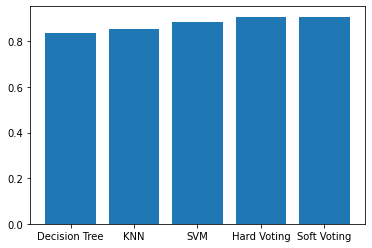

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)                                                                # 0부터 5개의 숫자들을 array 형태로 반환. 즉, [0, 1, 2, 3, 4]
plt.bar(
    x, 
    height = [
        accuracy_score(y_test, dtree_predicted),
        accuracy_score(y_test, knn_predicted),
        accuracy_score(y_test, svm_predicted),
        accuracy_score(y_test, hard_voting_predicted),
        accuracy_score(y_test, soft_voting_predicted)
    ]
)
plt.xticks(x, ['Decision Tree','KNN','SVM','Hard Voting','Soft Voting']);